In [1]:
#dependencies for helper functions/classes
import pandas as pd
import pyarrow.parquet as pq
from typing import NamedTuple
import os.path as path
import os
import progressbar
import requests
import numpy as np

#keras for ML
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout, Input, Dense
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.utils import plot_model, normalize
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, Adam, Nadam, Adadelta
from tensorflow.keras.activations import relu, elu, sigmoid

#sklearn for preprocessing the data and train-test split
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, classification_report
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, r2_score, mean_squared_error, mean_absolute_error

#for plots
import matplotlib
import matplotlib.pyplot as plt

seed = 7

#%matplotlib inline

In [2]:
class Labels(NamedTuple):
    '''
    One-hot labeled data
    '''
    tissue: np.ndarray
    sex: np.ndarray
    age: np.ndarray
    death: np.ndarray
        

class Genes:
    '''
    Class to load GTEX samples and gene expressions data
    '''
    def __init__(self, samples_path: str = '', expressions_path: str = '', problem_type: str = "classification"):
        self.__set_samples(samples_path)
        self.__set_labels(problem_type)
        if expressions_path != '':
            self.expressions = self.get_expressions(expressions_path)

    def __set_samples(self, sample_path: str) -> pd.DataFrame:
        self.samples: pd.DataFrame = pq.read_table(sample_path).to_pandas()
        self.samples["Death"].fillna(-1.0, inplace = True)
        self.samples: pd.DataFrame = self.samples.set_index("Name")
        self.samples["Sex"].replace([1, 2], ['male', 'female'], inplace=True)
        self.samples["Death"].replace([-1,0,1,2,3,4], ['alive/NA', 'ventilator case', '<10 min.', '<1 hr', '1-24 hr.', '>1 day'], inplace=True)
    
        return self.samples

    def __set_labels(self, problem_type: str = "classification") -> Labels:
        self.labels_list = ["Tissue", "Sex", "Age", "Death"]
        self.labels: pd.DataFrame = self.samples[self.labels_list]
        self.drop_list = self.labels_list + ["Subtissue", "Avg_age"]
        
        if problem_type == "classification":
            dummies_df = pd.get_dummies(self.labels["Age"])
            print(dummies_df.columns.tolist())
            self.Y = dummies_df.values
        
        if problem_type == "regression":
            self.Y = self.samples["Avg_age"].values
        
        return self.Y
    
    def delete_particular_age_examples(self):
        df_series = pd.DataFrame(self.labels["Age"])
        indexes_of_50 = np.where(df_series["Age"] == '50-59')[0].tolist()[300:]
        indexes_of_60 = np.where(df_series["Age"] == '60-69')[0].tolist()[300:]
        indexes_of_20 = np.where(df_series["Age"] == '20-29')[0].tolist()[300:]
        indexes_of_30 = np.where(df_series["Age"] == '30-39')[0].tolist()[300:]
        indexes_of_40 = np.where(df_series["Age"] == '40-49')[0].tolist()[300:]
        indexes_to_delete = indexes_of_50 + indexes_of_60 + indexes_of_20 + indexes_of_30 + indexes_of_40
        
        return indexes_to_delete

    def sex_output(self, model):
        return Dense(units=self.Y.sex.shape[1], activation='softmax', name='sex_output')(model)

    def tissue_output(self, model):
        return Dense(units=self.Y.tissue.shape[1], activation='softmax', name='tissue_output')(model)

    def death_output(self, model):
        return Dense(units=self.Y.death.shape[1], activation='softmax', name='death_output')(model)

    def age_output(self, model):
        '''
        Created an output layer for the keras mode
        :param model: keras model
        :return: keras Dense layer
        '''
        return Dense(units=self.Y.age.shape[1], activation='softmax', name='age_output')(model)


    def get_expressions(self, expressions_path: str)->pd.DataFrame:
        '''
        load gene expressions DataFrame
        :param expressions_path: path to file with expressions
        :return: pandas dataframe with expression
        '''
        if expressions_path.endswith(".parquet"):
            return pq.read_table(expressions_path).to_pandas().set_index("Name")
        else:
            separator = "," if expressions_path.endswith(".csv") else "\t"
            return pd.read_csv(expressions_path, sep=separator).set_index("Name")

    def prepare_data(self, normalize_expressions: bool = True)-> np.ndarray:
        '''
        :param normalize_expressions: if keras should normalize gene expressions
        :return: X array to be used as input data by keras
        '''
        data = self.samples.join(self.expressions, on = "Name", how="inner")
        ji = data.columns.drop(self.drop_list)
        x = data[ji]
        
        # adding one-hot-encoded tissues and sex
        x = pd.concat([x,pd.get_dummies(data['Tissue'], prefix='tissue'), pd.get_dummies(data['Sex'], prefix='sex')],axis=1)
        x = x.values
        
        return normalize(x, axis=0) if normalize_expressions else x
    
    def get_features_dataframe(self, add_tissues=True):
        data = self.samples.join(self.expressions, on = "Name", how="inner")
        ji = data.columns.drop(self.drop_list)
        df = data[ji]
        if add_tissues:
            df = pd.concat([df,pd.get_dummies(data['Tissue'], prefix='tissue'), pd.get_dummies(data['Sex'], prefix='sex')],axis=1)
        x = df.values
        min_max_scaler = MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        df_normalized = pd.DataFrame(x_scaled, columns=df.columns, index=df.index)
        return df_normalized


### Loading data

In [3]:
samples_path = 'data/gtex/v8_samples.parquet'
expressions_path = 'data/gtex/v8_expressions.parquet'

In [4]:
def Huber(yHat, y, delta=1.):
    return np.where(np.abs(y-yHat) < delta,.5*(y-yHat)**2 , delta*(np.abs(y-yHat)-0.5*delta))

def transform_to_probas(age_intervals):
    class_names = ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
    res = []
    for a in age_intervals:
        non_zero_index = class_names.index(a)
        res.append([0 if i != non_zero_index else 1 for i in range(len(class_names))])
    return np.array(res)
    
def transform_to_interval(age_probas):
    class_names = ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
    return np.array(list(map(lambda p: class_names[np.argmax(p)], age_probas)))        

### Preprocessing for Classification model

In [5]:
genes = Genes(samples_path, expressions_path, problem_type="classification")
X = genes.get_features_dataframe().values
Y = genes.Y

['20-29', '30-39', '40-49', '50-59', '60-69', '70-79']


In [6]:
X.shape, Y.shape

((17382, 18420), (17382, 6))

In [7]:
a = transform_to_interval(Y)
unique, counts = np.unique(a, return_counts=True)
dict(zip(unique, counts))

{'20-29': 1320,
 '30-39': 1323,
 '40-49': 2702,
 '50-59': 5615,
 '60-69': 5821,
 '70-79': 601}

In [8]:
b = [np.where(r==1)[0][0] for r in Y]
unique, counts = np.unique(b, return_counts=True)
dict(zip(unique, counts))

{0: 1320, 1: 1323, 2: 2702, 3: 5615, 4: 5821, 5: 601}

In [9]:
df_pie = pd.DataFrame(columns = ['age_group','label'])
df_pie['age_group'] = a
df_pie['label'] = b

# Plotting unbalanced pie chart

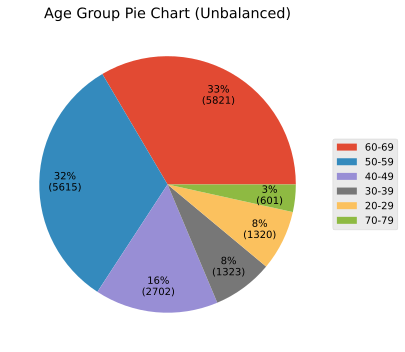

In [10]:
%matplotlib inline 
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
from matplotlib import pylab
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def my_fmt(x):
    # Change below to show more decimals, in percentage
    return '{:.0f}%\n({:.0f})'.format(x, total*x/100)

total = len(df_pie['age_group'])
plt.title('Age Group Pie Chart (Unbalanced)')
df_pie.age_group.value_counts().plot.pie(label='',figsize=(10,5), pctdistance=0.8,autopct=my_fmt, fontsize=10, legend=True,labeldistance=None);
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('images_other/pie_chart_unbalanced.png',dpi=1200)
plt.show()

# Balancing the data below

In [10]:
import numpy as np
def balanced_sample_maker(X, y, sample_size, random_seed=None):
    """ return a balanced data set by sampling all classes with sample_size 
        current version is developed on assumption that the positive
        class is the minority.

    Parameters:
    ===========
    X: {numpy.ndarrray}
    y: {numpy.ndarray}
    """
    uniq_levels = np.unique(y)
    uniq_counts = {level: sum(y == level) for level in uniq_levels}

    if not random_seed is None:
        np.random.seed(random_seed)

    # find observation index of each class levels
    groupby_levels = {}
    for ii, level in enumerate(uniq_levels):
        obs_idx = [idx for idx, val in enumerate(y) if val == level]
        groupby_levels[level] = obs_idx
    # oversampling on observations of each label
    balanced_copy_idx = []
    for gb_level, gb_idx in groupby_levels.items():
        over_sample_idx = np.random.choice(gb_idx, size=sample_size, replace=True).tolist()
        balanced_copy_idx+=over_sample_idx
    np.random.shuffle(balanced_copy_idx)

    return (X[balanced_copy_idx, :], y[balanced_copy_idx], balanced_copy_idx)

In [11]:
no_samples_to_take = 200
res = balanced_sample_maker(X,np.asarray(df_pie['age_group'].values), no_samples_to_take)

In [13]:
res[0]

array([[1.6064391e-02, 6.4456568e-04, 3.6726072e-01, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [8.6955316e-03, 9.5258076e-03, 1.5471010e-01, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [1.0219261e-02, 2.8955098e-02, 3.6141655e-01, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       ...,
       [1.1112962e-02, 1.7058329e-01, 2.4715841e-01, ..., 1.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 5.3378094e-02, 7.5606871e-01, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 4.9097773e-02, 5.5025154e-01, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00]], dtype=float32)

In [12]:
unique, counts = np.unique(res[1], return_counts=True)
dict(zip(unique, counts))

{'20-29': 200,
 '30-39': 200,
 '40-49': 200,
 '50-59': 200,
 '60-69': 200,
 '70-79': 200}

# Plotting balanced pie chart

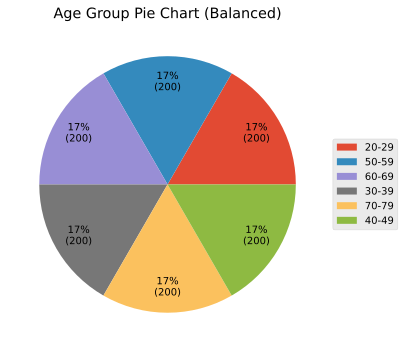

In [14]:
%matplotlib inline 
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
from matplotlib import pylab
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def my_fmt(x):
    # Change below to show more decimals, in percentage
    return '{:.0f}%\n({:.0f})'.format(x, total*x/100)

df_pie = pd.DataFrame(columns = ['age_group_unbalanced'])
df_pie['age_group_unbalanced'] = res[1]

total = len(df_pie['age_group_unbalanced'])
plt.title('Age Group Pie Chart (Balanced)')
df_pie.age_group_unbalanced.value_counts().plot.pie(label='',figsize=(10,5), pctdistance=0.8,autopct=my_fmt, fontsize=10, legend=True,labeldistance=None);
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('images_other/pie_chart_balanced.png',dpi=1200)
plt.show()

# Label encoding -->

In [14]:
le = LabelEncoder()
le.fit(res[1])
y = le.transform(res[1])

# Splitting data into different shards --> 

In [44]:
from sklearn import model_selection
X_1, X_2, y_1, y_2 = model_selection.train_test_split(res[0], y, test_size=0.5, random_state=seed, stratify=res[1])

In [45]:
_dtype = np.float32
y_1 = np.vstack(y_1).astype(np.uint8)
y_2 = np.vstack(y_2).astype(np.uint8)
X_1.dtype, y_1.dtype,X_2.dtype, y_2.dtype

(dtype('float32'), dtype('uint8'), dtype('float32'), dtype('uint8'))

In [46]:
unique, counts = np.unique(y_1, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(y_2, return_counts=True)
print(dict(zip(unique, counts)))

{0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100}
{0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100}


# One-hot encode the labels

In [50]:
Y[0]
y_1 = y_1.reshape(y_1.shape[0])
y_2 = y_2.reshape(y_2.shape[0])
y_2.shape

(600,)

In [51]:
# enc = OneHotEncoder()
# enc.fit(y_1)
# y_1 = enc.transform(y_1).toarray()
# y_1 = np.vstack(y_1).astype(np.uint8)

# enc = OneHotEncoder()
# enc.fit(y_2)
# y_2 = enc.transform(y_2).toarray()
# y_2 = np.vstack(y_2).astype(np.uint8)

# Saving data into npy format -->

In [52]:
data = [X_1, X_2, y_1, y_2]
label_ = ['shared_x1', 'shared_x2', 'shared_y1', 'shared_y2']
for i in range(len(data)):
    
    np.save('data/balanced/numpy_files/'+label_[i]+'.npy', np.asarray((data[i]), dtype=_dtype))